In [1]:
import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.interpolate import griddata



parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/"
geodesic=True
e=0

# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")


from ploters import ini_final_clusters
from ploters import gif_clusters
from ploters import ini_final_clusters_landmask
from ploters import gif_clusters_landmask
from calculating_borders import borders_binary

seasons = "JFM OND AMJ JAS"
# Split the string into a list of seasons
season_list = seasons.split()


def ini_final_clusters_landmask_borders(borders_avg, img_name, e, x, y, x_reg, y_reg, land_mask_plot,min_clusters,max_clusters):

    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()

    fig, ax = plt.subplots(figsize=(8, 6))
    # Define color map for the landmask
    #colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    #colors_mask = [(0.0, 0.0, 0.5), (1, 1, 1)]  # Deep blue and white
    colors_mask = [(0.968, 0.984, 1.0), (1, 1, 1)]  # Lightest blue in "Blues" and white
    #colors_mask = [(0.969, 0.969, 0.969), (1, 1, 1)]  # Lightest grey in "Greys" and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Interpolate the labels onto the grid


    #ax.pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)
    # Plot the initial distribution
    ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=land_mask_plot, cmap=colors_mask)
    im1 = ax.pcolormesh(x_reg,y_reg,borders_avg*100,cmap="Blues",alpha=1) #,vmin=0,vmax=40)
    

    #ax.imshow(mask_interpol, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone')
    
    contour_land = ax.contour(x, y, land_mask_plot, levels=0, cmap='bone', alpha=1)

    #im1 = ax.imshow(masked_borders_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r', alpha=0.7)

    # Add contour plot to the first subplot
    #contour_land = ax.contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
    ax.set_xlabel("Rotated Longitude", fontsize=16)
    ax.set_ylabel("Rotated Latitude", fontsize=16)
    ax.set_title("Frequency of cluster borders - "+str(min_clusters)+" to "+str(max_clusters)+" clusters")
    ax.set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
    ax.set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
    ax.set_aspect('equal', 'box')

    cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('%', fontsize=16)  # Optional: add a label to the colorbar
    # Main title
    #plt.suptitle(f"{n_clusters} clusters_{e} spars", fontsize=16)
    plt.subplots_adjust(right=0.8) 
    # Save the figure
    plt.savefig(f"{img_name}")
    # Show the plot
    plt.show()


In [38]:
def ini_final_clusters_landmask_borders_scalar(borders_avg, img_name, e, x, y, x_reg, y_reg, land_mask_plot,min_clusters,max_clusters,scalar):

    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()

    fig, ax = plt.subplots(figsize=(8, 6))
    # Define color map for the landmask
    #colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    #colors_mask = [(0.0, 0.0, 0.5), (1, 1, 1)]  # Deep blue and white
    colors_mask = [(0.968, 0.984, 1.0), (1, 1, 1)]  # Lightest blue in "Blues" and white
    #colors_mask = [(0.969, 0.969, 0.969), (1, 1, 1)]  # Lightest grey in "Greys" and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Interpolate the labels onto the grid

    scalar_ini = scalar[0, :, :]  # Assuming you want to show the first time slice
    #axes[0].pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)

    #axes[0].pcolormesh(x, y, scalar_ini, cmap="bone_r", alpha=1)
    im1 = ax.imshow(scalar_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r')
    #ax.pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)
    # Plot the initial distribution
    ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=land_mask_plot, cmap=colors_mask)
    borders_avg = np.where(borders_avg <= 0.4, np.nan, borders_avg)
    im2 = ax.pcolormesh(x_reg,y_reg,borders_avg*100,cmap="Blues",alpha=1) #,vmin=0,vmax=40)
    

    #ax.imshow(mask_interpol, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone')
    
    contour_land = ax.contour(x, y, land_mask_plot, levels=0, cmap='bone', alpha=1)

    #im1 = ax.imshow(masked_borders_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r', alpha=0.7)

    # Add contour plot to the first subplot
    #contour_land = ax.contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
    ax.set_xlabel("Rotated Longitude", fontsize=16)
    ax.set_ylabel("Rotated Latitude", fontsize=16)
    ax.set_title("Frequency of cluster borders - "+str(min_clusters)+" to "+str(max_clusters)+" clusters")
    ax.set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
    ax.set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
    ax.set_aspect('equal', 'box')

    cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    #cbar = plt.colorbar(im1, orientation='vertical')
    cbar.set_label('Sea ice thickness (m)')  # Optional: add a label to the colorbar

    cbar = fig.colorbar(im2, ax=ax, orientation='vertical', fraction=0.046, pad=0.15)
    cbar.set_label('%', fontsize=16)  # Optional: add a label to the colorbar
    # Main title
    #plt.suptitle(f"{n_clusters} clusters_{e} spars", fontsize=16)
    plt.subplots_adjust(right=0.8) 
    # Save the figure
    plt.savefig(f"{img_name}")
    # Show the plot
    plt.show()

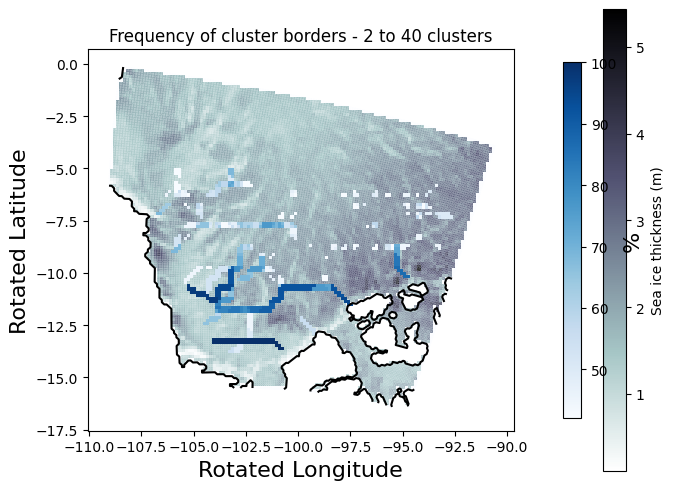

In [39]:
ini_final_clusters_landmask_borders_scalar(borders_2_40,results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg,land_mask_plot,2,40,sit)

In [15]:
geo_file_path = "/cluster/projects/nn8008k/lluisa/NextSIM/rotated_ice_velocities/special_cases/beaufort_zoom_lead_febmars/OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_90Rx_beaufort_zoom_lead_febmars_regrided.nc"
backgrun_file_path = "/cluster/projects/nn8008k/lluisa/NextSIM/rotated_ice_velocities/special_cases/beaufort_zoom_lead_febmars/OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_90Rx_beaufort_zoom_lead_febmars.nc"
file_path="/cluster/projects/nn8008k/lluisa/NextSIM/rotated_ice_velocities/special_cases/beaufort_zoom_lead_febmars/Fmap/ic0.5_dt0.0025_DT0.0250/"

Cluster_params = (
    f"geodesic_{geodesic}_"
    f"e{e:.2f}"
)

W_params = (
    f"geodesic_{geodesic}"
)

# Construct results directory path
results_directory = f"{file_path}" #/{Cluster_params}/"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

if not os.path.exists(results_directory):
    os.makedirs(results_directory)

dataset = nc.Dataset(geo_file_path, mode='r')

#from m/s to m/day
land_mask = dataset.variables['land_mask'][:]
latitude_reg = dataset.variables['regrided_rot_lat'][:]  
longitude_reg = dataset.variables['regrided_rot_lon'][:]
sit = dataset.variables['sit'][:,:,:]
dataset.close()

dataset = nc.Dataset(backgrun_file_path, mode='r')
# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]
siu = dataset.variables['vlon'][0,:,:]
land_mask_plot = siu[:,:].mask
dataset.close()

x=longitude
y=latitude
x_reg=longitude_reg
y_reg=latitude_reg



In [16]:
def process_clusters(min_clusters, max_clusters, file_path=file_path, x_reg=x_reg, y_reg=y_reg, results_directory=results_directory, Cluster_params=Cluster_params, e=e, longitude=longitude, latitude=latitude, land_mask_plot=land_mask_plot, ):
    Fmap_path = file_path+'Fmap_geodesic_True_nclusters'+str(min_clusters)+'_e0.00.npy'
    labels_path = file_path+'Clusters_labels_geodesic_True_nclusters'+str(min_clusters)+'_e0.00.npy'
    # Load the Fmap array from the file
    Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    labels= np.load(labels_path)

    grid_labels = griddata((IC[0, :], IC[1, :]), labels, (x_reg,y_reg), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels, (x_reg,y_reg), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(fmap_mask,np.nan, borders_avg)
    borders_avg[borders_avg > 0] = 1
    for n_clusters in range(min_clusters+1, max_clusters):
        # Construct the file paths with the current value of n_clusters
        Fmap_path = file_path + f'Fmap_geodesic_True_nclusters{n_clusters}_e0.00.npy'
        labels_path = file_path + f'Clusters_labels_geodesic_True_nclusters{n_clusters}_e0.00.npy'
        
        # Load the Fmap array from the file
        Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
        IC = Fmap[0, :, :]  # Take the position of the trajectory IC
        
        # Load the labels of the clusters
        labels = np.load(labels_path)
        
        # Interpolate the labels onto the grid
        grid_labels = griddata((IC[0, :], IC[1, :]), labels, (x_reg, y_reg), method='nearest')
        fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels, (x_reg, y_reg), method='linear'))
        
        # Calculate borders
        borders = borders_binary(grid_labels)
        borders = np.where(fmap_mask, np.nan, borders)
        borders[borders > 0] = 1
        
        # Accumulate the borders
        borders_avg += borders
    
    # After the loop, borders_avg will contain the accumulated borders
    borders_avg = np.where(borders_avg == 0, np.nan, borders_avg)
    borders_avg = np.where(land_mask == 1, np.nan, borders_avg)
    borders_avg = borders_avg / (max_clusters-min_clusters)
    # Call the final processing function
    ini_final_clusters_landmask_borders(borders_avg, results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg, land_mask_plot, min_clusters, max_clusters)
    return borders_avg
                                                    
# Example usage:
# process_clusters(file_path, x_reg, y_reg, land_mask, ntimesteps, results_directory, Cluster_params, e, longitude, latitude, land_mask_plot)

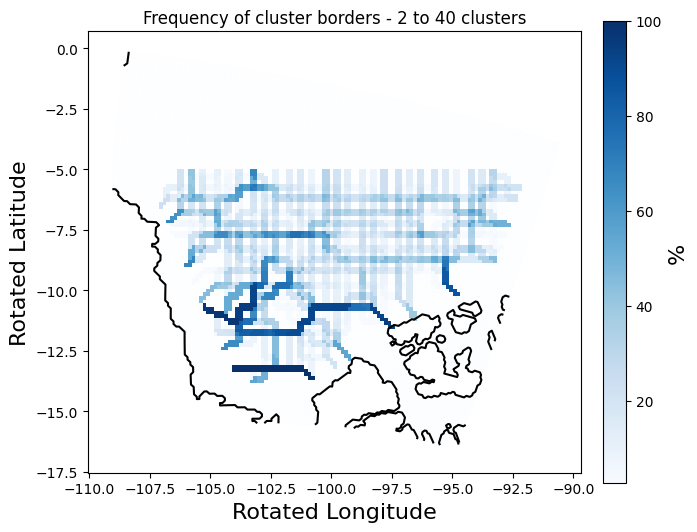

In [17]:
borders_2_40 = process_clusters(2,40)

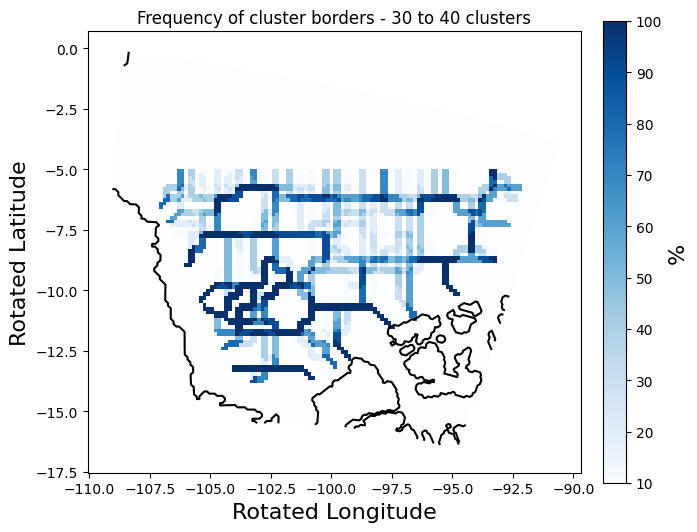

In [18]:
borders_30_40 = process_clusters(30,40)

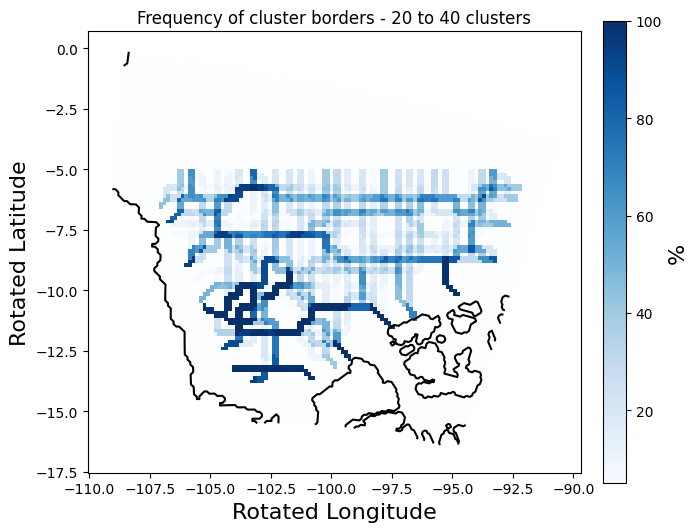

In [19]:
borders_20_40 = process_clusters(20,40)

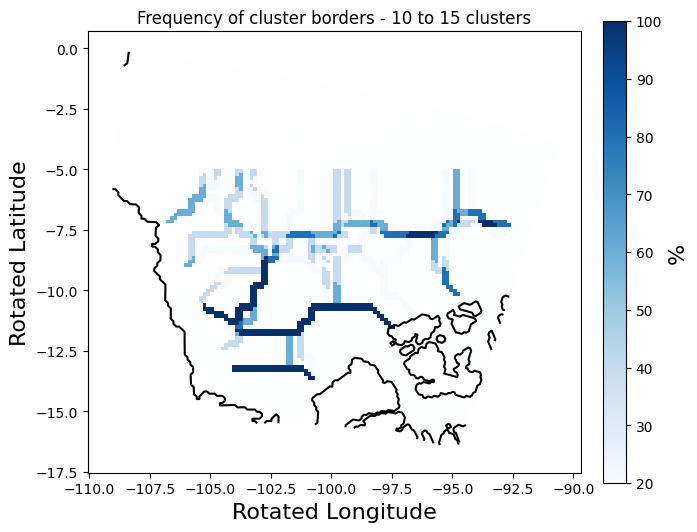

In [20]:
borders_2_10 = process_clusters(10,15)

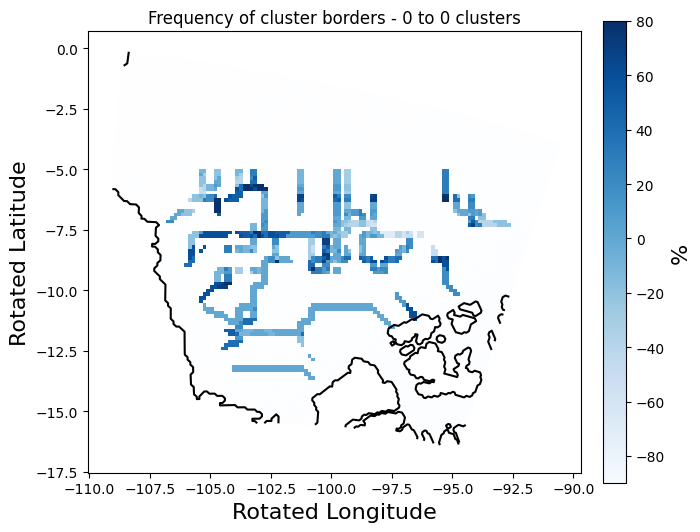

In [21]:
ini_final_clusters_landmask_borders(borders_30_40-borders_2_10, results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg,land_mask_plot, 0,0)

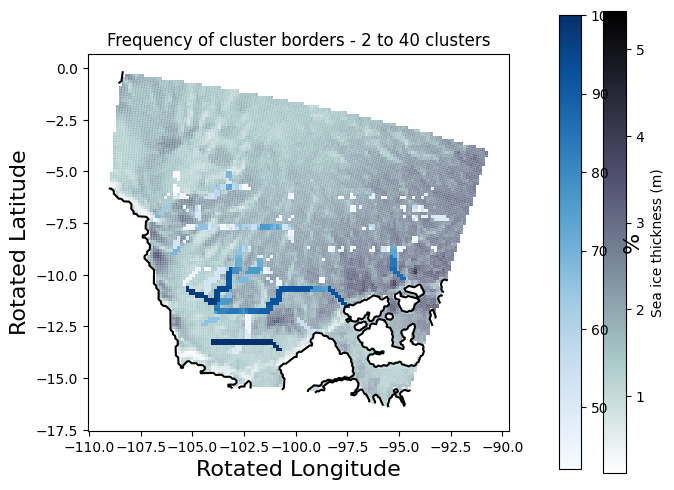

In [37]:
ini_final_clusters_landmask_borders_scalar(borders_2_40,results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg,land_mask_plot,2,40,sit)

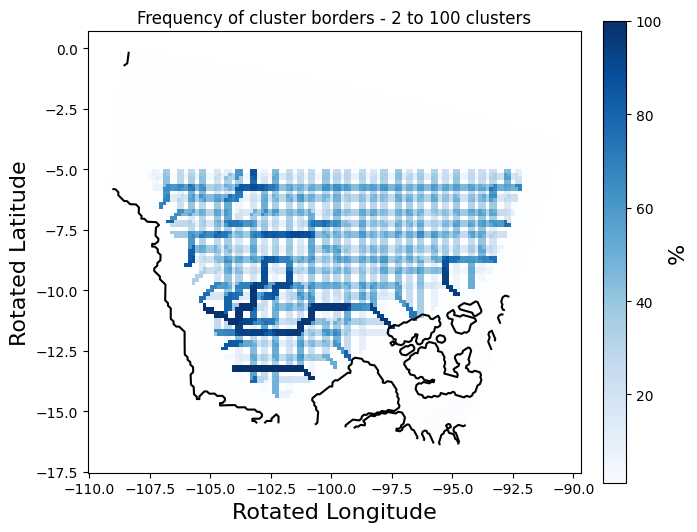

In [27]:
borders_20_40 = process_clusters(2,100)

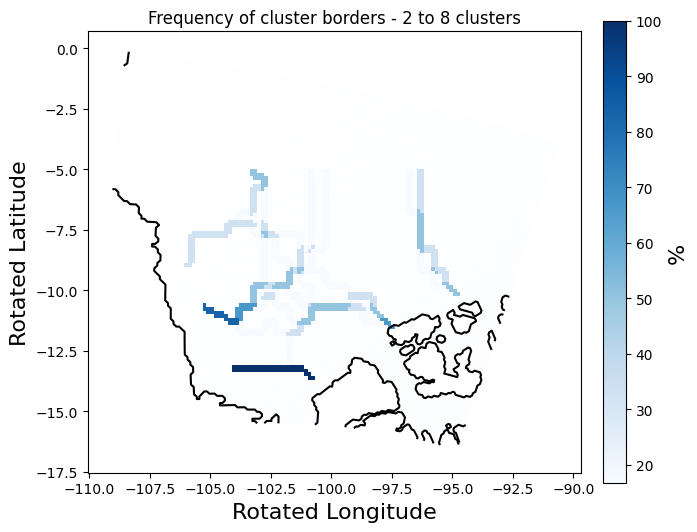

In [33]:
borders_20_40 = process_clusters(2,8)